# Graded assignment 1 - text classification using Genetic Algorithms
In this assignment we'll make a binary text classifier using neural networks and train it using genetic algorithms. We will classify movie reviews from IMDB as either negative or positive. 

The assignment text contain 3 steps, so I divided the assignment in 3 sections:

1. Preprocessing of the text
2. Genetich Algorithm
3. Testing

**Preprocessing text**

First I uploaded all data and put them together. Then I explore the dataset, explore the use of vocabulary distribution, review length distribution.

After analyzing data I split them into training, validation and testing set. Then I preprocessed the text using different methods like removing stop words, lemmatization etc.

Training set will be used to build vocabulary and IDF values. Validation set will be used when assigning fitness in Genetic Algorithm which I'll get into more. Testing set will be used at the end in validation part for a final evaluation.

What we basically doing here is to try to predict what class a text belongs to based on how many of which words the text contains. Our classifier must recognize that some words convey positive sentiment, some convey negative sentiment and some make no difference. The latter words don't help with predictions. That's why we do preprocessing and turn all the reviews into equally sized vectors representing the frequency and importance of each word which can be proceeded by our neural network. How we do the preprocessing will be further explained later.


I have built two classes for preprocessing stage. One is TextPreprocessor which processes contents with methods like removing stop words, lemmatization etc.

The other is TF-IDF vectorizer class which is used to build a Numpy array of TF-IDF vectors. Each document is turned into a TF-IDF vector.

**Genetic Algorithm**
Genetic algorithm  (often referred as GA) is an algorithm inspired by evolution theory. Here rather than species we have solutions to a problem. We call those solutions for Chromosomes. In this case Chromosomes are just weights for a neural network. We use methods like "cross-over" and "mutation" to make changes in those Chromosomes, and we try to pick the best Chromosome. In here the best Chromosome is 

The classifier I used is a simple neural network. I considered decision tree, but I'm not familiar with decision trees while I'm a bit familiar with neural network. Thus I decided to go with neural network. 

The neural net has only 2 hidden layers, 16 and 8 hidden nodes. I kept it simple because I had to take hardware limitations into account too. In early trials, this architecture seemed more than capable of learning from the training set. In the Genetic Algorithm I will train with the trainign dataset but I will calculate fitness using the validation set for each classifier. This will avoid overfitting the training set.

**Testing**
The validation data is simply using the optimizied weights to predict all reviews in the testing set to see how our GA performs - that is, to determine its fitness. In the assignment text they suggested to use testing set for assigning fitness in GA and in validation part. But I thought that using the same data for GA improvement and evaluation would led to overfitting. Thus, other than training set, I used two separate sets: validation set and testing set. Validation set will be used when assigning fitness while optimizing weights in GA. Testing set will be used at the end.

## 1. Preprocessing

The preprocessing consists of two parts. Preproceesing the texts in the dataframe, and then converting the texts into vectors that can be used in classifier.

I have built twp seperate classes for each one. TextPreprocessor class and TF-IDF vectorizer.

I searched online about different vectorizartion methods in text classifying. I found TF-IDF vectorization contains more data than others, which could help in classifying. With TF-IDF vectors one can see which words are more "special" than others.

### 1.1 Uploading data

All the data is placed in four seperate folders. I found PlainTextCorpusReader from nlkt.corpus to be more effective in reading multiple text files. 




In [94]:
## Upload the text
import numpy as np
import pandas as pd
import math
import random
from scipy import special

import nltk
import string
import re
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import PlaintextCorpusReader
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import FreqDist
from nltk.corpus import stopwords

from collections import Counter

import matplotlib.pyplot as plt


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\abdka\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abdka\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


I used for loop iteration to extract the info as array. Then I made a dataframe where I put all the samples together.

The data contains 3 columns (among index): reviews (the content of TXT files), labels (positive or negative, 1 or 0), and rates (extracted from file names).

I haven't used rate values anywhere in the assignment. I planned to use them but didn't use them. But still I didn't remove them so the code can be further developed.


In [3]:
# File directories
corpus_train_pos_root = 'aclImdb/train/pos/'
corpus_train_neg_root = 'aclImdb/train/neg/'
corpus_test_pos_root = 'aclImdb/test/pos/'
corpus_test_neg_root = 'aclImdb/test/neg/'

# Corpus file objects
files_train_pos = PlaintextCorpusReader(corpus_train_pos_root, '.*')
files_train_neg = PlaintextCorpusReader(corpus_train_neg_root, '.*')
files_test_pos = PlaintextCorpusReader(corpus_test_pos_root, '.*')
files_test_neg = PlaintextCorpusReader(corpus_test_neg_root, '.*')


# Getting review texts, labels and rates from all folders in arrays
reviews_train_pos = [files_train_pos.open(n).read() for n in files_train_pos.fileids()]
rates_train_pos = [int(re.split("_|\.", n)[-2]) for n in files_train_pos.fileids()]
labels_train_pos = [1] * len(reviews_train_pos)

reviews_train_neg = [files_train_neg.open(n).read() for n in files_train_neg.fileids()]
rates_train_neg = [int(re.split("_|\.", n)[-2]) for n in files_train_neg.fileids()]
labels_train_neg = [0] * len(reviews_train_neg)

reviews_test_pos = [files_test_pos.open(n).read() for n in files_test_pos.fileids()]
rates_test_pos = [int(re.split("_|\.", n)[-2]) for n in files_test_pos.fileids()]
labels_test_pos = [1] * len(reviews_test_pos)

reviews_test_neg = [files_test_neg.open(n).read() for n in files_test_neg.fileids()]
rates_test_neg = [int(re.split("_|\.", n)[-2]) for n in files_test_neg.fileids()]
labels_test_neg = [0] * len(reviews_test_neg)

In [4]:
whole_set = pd.DataFrame()

# Puttin all data into whole set
whole_set['review'] = reviews_train_pos + reviews_test_pos + reviews_train_neg + reviews_test_neg
whole_set['rate'] = rates_train_pos + rates_test_pos + rates_train_neg + rates_test_neg
whole_set['label'] = labels_train_pos + labels_test_pos + labels_train_neg + labels_test_neg

### 1.2 Data exploration

Here we explore how the data looks like. That is to figure out how to preprocess the data, what to eliminate etc. We start it by looking at some samples

In [5]:
whole_set.sample(5)

,review,rate,label
18988,We just saw this movie in Austin Texas at the ...,10,1
31848,I love a good sappy love story (and I'm a guy)...,1,0
365,Trio's vignettes were insightful and quite enj...,8,1
4606,Legendary movie producer Walt Disney brought t...,10,1
36620,"First off, I knew nothing about 'Mazes and Mon...",1,0


#### 1.2.1 Most common words

We print the most common words both in terms of total frequency and frequency in terms of number of reviews it appears.

In [6]:
# Data exploration
# Most common words

cnt = Counter()
cnt2 = Counter()
for text in whole_set["review"].values:
    # Counting the words
    for word in text.split():
        cnt[word] += 1
    # Counting in how many reviews the word appears
    for word in set(text.split()):
        cnt2[word] += 1

print("Most common 20 counted by appearance in nr of reviews: ", cnt2.most_common(20))
print("\nMost common 20 counted by word count total: ", cnt.most_common(20))

# print("Least common 20 counted by appearance in nr of reviews: ", cnt2.most_common()[:-20])
# print("\nLeast common 20 counted by word count total: ", cnt.most_common()[:-20])


Most common 20 counted by appearance in nr of reviews:  [('the', 49298), ('a', 48048), ('and', 47886), ('of', 47322), ('to', 46839), ('is', 44366), ('in', 43163), ('this', 41446), ('that', 38943), ('it', 37931), ('I', 35924), ('for', 34503), ('with', 33960), ('but', 32072), ('was', 31866), ('The', 31164), ('as', 30498), ('on', 29824), ('/><br', 29200), ('have', 28109)]

Most common 20 counted by word count total:  [('the', 568735), ('a', 306960), ('and', 301919), ('of', 283625), ('to', 261850), ('is', 203056), ('in', 169981), ('I', 132498), ('that', 126818), ('this', 113726), ('it', 107916), ('/><br', 100974), ('was', 92658), ('as', 83130), ('with', 82569), ('for', 80919), ('The', 67317), ('but', 66282), ('on', 61197), ('movie', 60762)]


As seen there are a lot of stop words. There are HTML tags in the set too. The stop words and HTML tags will be removed in with TextPreprocessor class.

Vocabulary here means all the words used in the training set. The vocabulary will be based on training set.

#### 1.2.2 Plot vocabulary distribution

Here we plot what % of the reviews use what % of the vocabulary.

Text(0, 0.5, '% of documents')

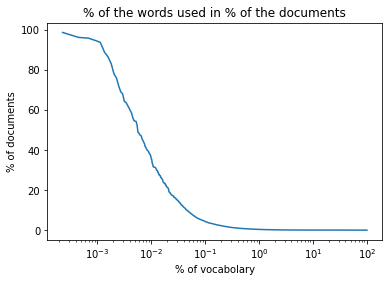

In [7]:
# What % of the reviews use what % of the vocab
vocab_size = len(cnt2)
sample_size = len(whole_set)

y = [c/sample_size * 100 for (w, c) in cnt2.most_common()]
x = [c/vocab_size * 100 for c in range(1, vocab_size+1)]


fig, ax = plt.subplots()

ax.plot(x, y)
ax.set_title("% of the words used in % of the documents")
ax.set_xscale('log')
ax.set_xlabel("% of vocabolary")
ax.set_ylabel("% of documents")

The graph above shows how much % of the vocabulary is used by how much % of the documents.

We see that only a tiny fraction of the vocubulary are used in most of the documents. 
Most of the words in vocabulary are rare words, also they're used only in a small fraction of the documents.

#### 1.2.3 Reviews length distribution

Here we plot histogram of lengthts of reviews.

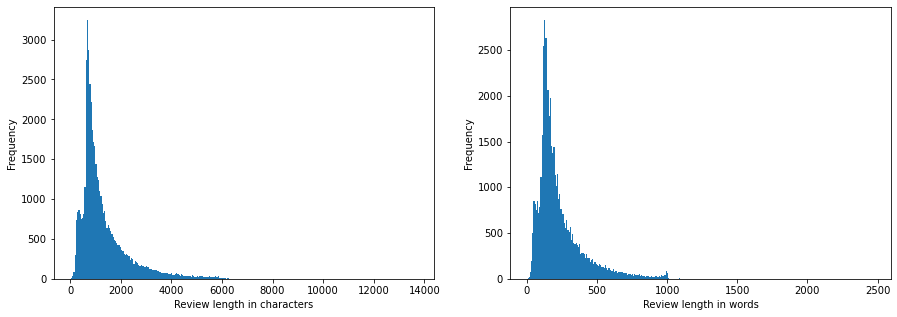

In [8]:
# Length distribution of the reviews
whole_set['rev_lens_raw'] = whole_set['review'].str.len()
whole_set['rev_lens_words'] = whole_set['review'].str.split().apply(len)
fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].hist(whole_set['rev_lens_raw'], bins='auto')
ax[0].set_xlabel("Review length in characters")
ax[0].set_ylabel("Frequency")
ax[1].hist(whole_set['rev_lens_words'], bins='auto')
ax[1].set_xlabel("Review length in words")
ax[1].set_ylabel("Frequency")

plt.show()

The histograms above shows distribution of frequency and review length. The longest reviews are 1000 words which is not very unusual. 

We want to see if short reviews contain garbage, and to check they look like normal movie reviews.

We might consider removing the very long reviews as these use many words of positive and negative sentiment and can be very nebulous and therefore offer poor training signal.

#### 1.2.4. See some samples

We want to see if short reviews contain garbage, and see they look like normal movie reviews.

We want to see some samples too

In [9]:
# Shortest reviews
whole_set.nsmallest(10, 'rev_lens_words')['review'].values

array(['Primary plot!Primary direction!Poor interpretation.',
       'Read the book, forget the movie!',
       'I hope this group of film-makers never re-unites.',
       'More suspenseful, more subtle, much, much more disturbing....',
       'What a script, what a story, what a mess!',
       'Brilliant and moving performances by Tom Courtenay and Peter Finch.',
       'This movie is terrible but it has some good effects.',
       "I wouldn't rent this one even on dollar rental night.",
       "You'd better choose Paul Verhoeven's even if you have watched it.",
       'Adrian Pasdar is excellent is this film. He makes a fascinating woman.'],
      dtype=object)

In [10]:
# Drop reviews that are very long
#train_set = train_set.loc[train_set['rev_lens_word'] < 1800]
#train_set.reset_index(inplace=True, drop=True)


### 1.3 Splitting data

The original sample was split 50% was testing and 50% for training. That's too little for training and too much for testing. And there's no validation dataset.

Thus I made the split into three: 
* 70 % on training, 
* 15 % on testing
* 15 % on validation.

Splitting the data into three sets where training set is significantly bigger is common in machine learning.

TF-IDF vectors will be based on training set. Thus we need training set to be in bigger size.

Validation set will be used in Genetic Algorithm when assigning fitness to classifiers.
Too big validation set could slow it the GA much.

Testing set will be used at the end to test how much the "trained classifier" performs.

Then I shuffle the data.

In [11]:
# Putting all into two Pandas dataframes - training set and testing set
train_set = pd.DataFrame()
test_set = pd.DataFrame()
valid_set = pd.DataFrame()

# Dividing reviews into negative and positive to make sure data is always balanced
negatives = whole_set.loc[whole_set['label'] == 0]
positives = whole_set.loc[whole_set['label'] == 1]

# Splitting positive and negative reviews
train_set, valid_set, test_set = np.split(positives, [int(0.7*len(positives)), int(0.85*len(positives))])
tr_neg, vl_neg, ts_neg = np.split(negatives, [int(0.7*len(negatives)), int(0.85*len(negatives))])



# Appending negatives to positives
train_set = train_set.append(tr_neg)
valid_set = valid_set.append(vl_neg)
test_set = test_set.append(ts_neg)

# Shuffle and reset the index
train_set = train_set.sample(frac=1).reset_index(drop=True)
valid_set = valid_set.sample(frac=1).reset_index(drop=True)
test_set = test_set.sample(frac=1).reset_index(drop=True)

train_set

,review,rate,label,rev_lens_raw,rev_lens_words
0,I did not watch the entire movie. I could not ...,3,0,1624,283
1,"Yes, it can be done. John De Bello and Costa D...",2,0,762,139
2,Too bad Chuck Norris has gone to TV. He made s...,4,0,231,46
3,"Kubrick proved his brilliantness again, now in...",10,1,1704,291
4,"Sorry, gave it a 1, which is the rating I give...",2,0,213,44
...,...,...,...,...,...
34995,I was expecting a B-Movie French musical. Afte...,1,0,729,133
34996,This is one of my all time favorites.<br /><br...,10,1,639,111
34997,This movie completely ran laps around the orig...,10,1,885,161
34998,"""Convicts"" is very much a third act sort of fi...",7,1,1701,287


### 1.4 Preprocessing and and vectorization

Prerocessing and vectorization serves differ goals. The goal of preprocessing is to clean and normalize the data to best reflect its sentiment by eliminating noise. The purpose of vectorization is to present a uniform numerical representation of text data that is fit for consumption by our neural network classifier. 

What we basically want to do here is to try to predict what class a text belongs to by making some calculations based on how many of which words in the vocabulary that particular text contains. 

So we want to build a vocabulary first, a list of words in the training set. But we don't want to include absolutely all words used in the training set to be included in the vocabulary. Thus we make some preprocessing, some filtering etc. and that's where TextPreprocessor comes in.

E.g. stopwords like "the", "a", "and" etc. don't say anything about whether the review is positive or negative. Thus in the preprocessing stage we eliminate them. We eliminate numbers and other words too that don't give meaning.

Very common words, words that are used in almost all reviews, don't say much about if the review is negative or positive. So we eliminate most common words too. But very rare words also don't say much about 

To keep variations of the same word inflating the vocabulary size (and reducing the performance of our classifier) we will use lemmatization.

#### 1.4.1 TextPreprocessor class

Most of the functions are in this class are taken from a code posted on Canvas. I just put hem into a class, made some changes and built some additional functions.

Preprocessing is done with a function in TextProcessor class named def `preprocess_imdb_reviews()` which uses other functions in the class. It processes all the text in a dataframe under column "review" and returns a dataframe with additional column named "processed" where all processed text are saved. I keep both of them to be able to repeat code and to make a comparison later.

The functions are applied by using .apply() function of the dataframe, which apply a function to each row in a chosen column.

As mentioned we don't want to include all words used in the training set to be included in the vocabulary. Thus we make some changes. Here is how we process the text:
1. We make all lower cases. Some people use upper case to highlight their words, and first letter of words are in upper case after periods. All all those words mean the same thing, so we don't want to discriminate between those. The only problem here is that movie names and person names would be processed just like some words. E.g. the movie "Cars" would be interpreted as noun in plural form cars, and eventually be lemmatized into car or removed. But it's very difficult to write a code to determine what is movie / person name or not, and they don't say much about whether a movie review is positive or negative. Thus for now we just ignore this problem. Lower casing all words also makes other processing steps easier.
2. We remove HTML tags. They are not words with meaning, just some clutter to be removed.
5. We remove URLs. They are not words with meaning, so just remove them.
3. We convert emoticons into text. We do this before removing numbers or anything else as emoticons may contain numbers too. We don't want to remove them as they may contain useful information about the review.
4. We remove numbers. They can be dates, ages etc. which don't give much relevant info about the review.
6. We expand contractions. Alos "don't" means same as "do not". So we don't want to distinguish between those. Expanding contractions also will make removing stop words easier. It's important to do it early as it will generate new stop words.
7. We remove emojis
8. We remove punctuations, like dots and slashes. In computers "something" and "something," are perceived as two different words, we don't want that.
9. We lemmatize words. Lemmatizing means converting words to base forms.E.g. "boring" and "bored" are same words, "child" and "children" are actually same word. We want the computer to perceive them as same words too. Words with same base should be considered as same word.
10. We remove the stop words. Words like "the", "a", "and" may be used in all reviews and don't give any information about review. So we just remove them.
11. Curbing. We remove the words that exists in more than 85 % of the documents. They are some common words that don't give much context. And we remove the words that exists in less than 0.05 % of the documents. Rare words are words like special movie names, actor names, weirdo words, misspesllings etc. Words that are used only here and there or only in one review can't be used in calculating which class a reviews belongs to. The rates 0.85 and 0.0005 are paramaters to the function. I experimented with different values, I don't want to end up with vocabulary that's too little, but nor too big. Most of the words in vocabulary are rare words that are used in tiny fraction of the set. Thus the bottom curb is just 0.0005. Too little vocabulary give too little information. Too big vocabulary is too heavy for the neural network, and may contain a lot of words that give little information. A vocabulary of 10k-20k is enough. After experiemting with different values I did choose 0.85 and 0.0005 as curbing values.
12. At the end I found some garbage words still existing in the set. I made an array of those and removed those from all the reviews. The array is: ["□", "▢", "■", "\x96", "st", "nd", "rd", "th"]. \x96 is just some triangle. st, nd, rd and th are remainders of numerical values like 1st, 2dn, 3rd, 4th etc. which is meaningless.








In [12]:
# I think to put this into own .PY file and import from there
class TextPreprocessor():
    """
    This is a class for processing text and text in Pandas Dataframes
      
    Attributes:
        stop_words (set): list of stop words from nltk library
        punctuation: list of punctuations from 'strin' library
        emoji_pattern (list): a compiled emoji patternt for processing emojis
        emoticons (list): a dictionary of emoticons and descriptive text
        url_pattern: re.compile of URL pattern for removing URLs
        html_pattern: re.compile of HTML pattern for removing HTML tags
    """
    
    def __init__(self):
        """
        The constructor for TextPreprocessor class
        """
        
        nltk.download('stopwords')
        nltk.download('wordnet')
        ", ".join(stopwords.words('english'))
        
        self.stop_words = set(stopwords.words('english'))
        
        self.punctuation = string.punctuation
        
        self.emoji_pattern = re.compile("["
                                u"\U0001F600-\U0001F64F"  # emoticons
                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                u"\U00002702-\U000027B0"
                                u"\U000024C2-\U0001F251"
                                "]+", flags=re.UNICODE)
        
        # src : https://github.com/NeelShah18/emot/blob/master/emot/emo_unicode.py
        self.emoticons = {
            u":‑\)":"Happy face or smiley",
            u":\)":"Happy face or smiley",
            u":-\]":"Happy face or smiley",
            u":\]":"Happy face or smiley",
            u":-3":"Happy face smiley",
            u":3":"Happy face smiley",
            u":->":"Happy face smiley",
            u":>":"Happy face smiley",
            u"8-\)":"Happy face smiley",
            u":o\)":"Happy face smiley",
            u":-\}":"Happy face smiley",
            u":\}":"Happy face smiley",
            u":-\)":"Happy face smiley",
            u":c\)":"Happy face smiley",
            u":\^\)":"Happy face smiley",
            u"=\]":"Happy face smiley",
            u"=\)":"Happy face smiley"
        }
        
        self.url_pattern = re.compile(r'https?://\S+|www\.\S+')
        self.html_pattern = re.compile('<.*?>')

    def lower_case(self, text):
        """
        Lowercase all characters in the string and returns the string.
        """
        return str.lower(text)
    
    def remove_punctuation(self, text):
        """
        Removes all punctuations in the string and returns the string.
        """
        return text.translate(str.maketrans('', '', self.punctuation))
    
    def remove_stopwords(self, text):
        """
        Removes all stop words in the string and returns the string.
        """
        return " ".join([word for word in text.split() if word not in self.stop_words])
    
    def remove_words(self, text, words_list):
        """
        Removes words determined in the list from the string and returns the string back.
  
        Parameters:
            text (string): a string to be processed
            words_list (list): a list that containts list of words that'll be removed from the string
          
        Returns:
            string: the processed text where the words in the list are removed
        """
        
        return " ".join([word for word in text.split() if word not in words_list])
    
    def remove_emoji(self, text):
        """
        Removes all emoji in the string and returns the string.
        """
        # src: https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
        return self.emoji_pattern.sub(r'', text)
    
    
    def remove_emoticons(self, text):
        """
        Removes all emoticons in the string and returns the string.
        """
        # src : https://github.com/NeelShah18/emot/blob/master/emot/emo_unicode.py
        emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in self.emoticons) + u')')
        return emoticon_pattern.sub(r'', text)
    
    def convert_emoticons(self, text):
        """
        Converts all emoticons to descriptive text and returns the text back
        
        How it converts can be found here: https://github.com/NeelShah18/emot/blob/master/emot/emo_unicode.py
        """
        # src : https://github.com/NeelShah18/emot/blob/master/emot/emo_unicode.py
        for emot in self.emoticons:
            text = re.sub(u'('+emot+')', "_".join(self.emoticons[emot].replace(",","").split()), text)
        return text
    
    def lemmatization(self, text):
        """
        Lemmatizes each verbs, nouns and adverts in the string and returns the string back
        
        E.g. it turns "cars" into "car", "children" to "child". 
        All words are converted to their base form.
        """
        lemmatizer = WordNetLemmatizer()
        tokens = word_tokenize(text)
        for i in ['v','n','a']:
            tokens = [lemmatizer.lemmatize(word, i) for word in tokens]
        return " ".join(tokens)
    
    def expand_contractions(self, text):
        """
        Expands all contractions in the string and returns the string back
        
        E.g. "i'm" converted to "i am". "haven't" converted to "have not".
        All characters must be in lower case for the function to work.
        The text needs to be processed with lower_case() function first
        """
        text = re.sub(r"i'm", " i am ", text)
        text = re.sub(r" im ", " i am ", text)
        text = re.sub(r"\: p", "", text)
        text = re.sub(r" ive ", " i have ", text)
        text = re.sub(r" he's ", " he is ", text)
        text = re.sub(r" she's ", " she is ", text)
        text = re.sub(r" that's ", " that is ", text)
        text = re.sub(r" what's ", " what is ", text)
        text = re.sub(r" where's ", " where is ", text)
        text = re.sub(r" haven't ", " have not ", text)
        text = re.sub(r" ur ", " you are ", text)
        text = re.sub(r"\'ll", " will", text)
        text = re.sub(r"\'ve", " have", text)
        text = re.sub(r"\'re", " are", text)
        text = re.sub(r"\'d", " would", text)
        text = re.sub(r" won't ", " will not ", text)
        text = re.sub(r" wouldn't ", " would not ", text)
        text = re.sub(r" can't ", " cannot ", text)
        text = re.sub(r" couldn't ", " could not ", text)
        text = re.sub(r" couldnt ", " could not ", text)
        text = re.sub(r" don't ", " do not ", text)
        text = re.sub(r" dont ", " do not ", text)
        text = re.sub(r" didn't ", " did not ", text)
        text = re.sub(r" didnt ", " did not ", text)
        text = re.sub(r" doesn't ", " does not ", text)
        text = re.sub(r" doesnt ", " does not ", text)
        text = re.sub(r" isn't ", " is not ", text)
        text = re.sub(r" isnt ", " is not ", text)
        text = re.sub(r" it's ", " it is ", text)
        text = re.sub(r" who's ", " who is ", text)
        text = re.sub(r" there's ", " there is ", text)
        text = re.sub(r" theres ", " there is ", text)
        text = re.sub(r" weren't ", " were not ", text)
        text = re.sub(r" werent ", " were not ", text)
        text = re.sub(r" wasn't ", " was not ", text)
        text = re.sub(r" wasnt ", " was not ", text)
        text = re.sub(r" ok ", " okay ", text)
        text = re.sub(r" you're ", " you are ", text)
        text = re.sub(r" c'mon ", " come on ", text)
        text = re.sub(r"\'s", " s", text)
        return text
    
    def remove_numbers(self, text):
        """
        Removes all the numbers from the string and returns the string back
        """
        text = re.sub(r'[0-9]', '', text)
        return text
    
    def remove_html_tags(self, text):
        """
        Removes all HTML tags from the string and returns the string back
        """
        return self.html_pattern.sub(r'', text)
    
    def remove_urls(self, text):
        """
        Removes all the URLs from the string and returns the string back
        """
        return self.url_pattern.sub(r'', text)
    
    
    # preprocessing IMDB reviews
    def preprocess_imdb_reviews(self, df, max_df, min_df):
        """
        Preprocessing IMDB reviews saved in a Pandas Dataframe 
        and returns a Dataframe with additional column.
        
        It preprocesses IMDB reviews by lower casing all letter, removing HTML tags, 
        emojis, numbers, converting emoticons to descriptive text, removes punctioation, 
        stop words and lemmatization. Then it removes most and least frequent words based
        on percentage of appearerance in the dataframe. The percentages are passed as
        parameters as rates between 0 and 1. Then it removes some more garbage words.
        
        Parameters:
            df (Pands Dataframe): a Pandas Datframe. The strings must be in column named 'review'
            max_df (float): A rate between 0-1. To remove words that appear more than max_df of the rows
            min_df (float): A rate between 0-1. To remove words that appear less than min_df of the rows
          
        Returns:
            Pandas Dataframe: The same Pandas Dataframe with additional column named 'processed' where all
            processed text are saved.
        
        """
        
        df['processed'] = df['review'].apply(lambda text: self.lower_case(text))
        df['processed'] = df['processed'].apply(lambda text: self.remove_html_tags(text))
        df['processed'] = df['processed'].apply(lambda text: self.remove_urls(text))
        df['processed'] = df['processed'].apply(lambda text: self.convert_emoticons(text))
        df['processed'] = df['processed'].apply(lambda text: self.remove_numbers(text))
        df['processed'] = df['processed'].apply(lambda text: self.expand_contractions(text))
        df['processed'] = df['processed'].apply(lambda text: self.remove_emoji(text))
        df['processed'] = df['processed'].apply(lambda text: self.remove_punctuation(text))
        df['processed'] = df['processed'].apply(lambda text: self.lemmatization(text))
        df['processed'] = df['processed'].apply(lambda text: self.remove_stopwords(text))


        
        cnt2 = Counter()
        for text in df['processed'].values:
            # Counting the words
            for word in set(text.split()):
                cnt2[word] += 1


        # Remove words used in >max_df% and <min_df% of the reviews
        curb_max_amount = len(df) * max_df
        curb_min_amount = len(df) * min_df
        curb_words = set([w for (w, wc) in cnt2.most_common() if wc > curb_max_amount or wc < curb_min_amount])
        df['processed'] = df['processed'].apply(lambda text: self.remove_words(text, curb_words))
        
        # Other words to remove
        rem_words = ["\x96", "st", "nd", "rd", "th"]
        df['processed'] = df['processed'].apply(lambda text: self.remove_words(text, rem_words))

        return df


#### 1.4.3 Preprocessing

Here we preprocess training set, testing set and validation set.

In [13]:
#Using the preprocessor
preprocessor = TextPreprocessor()
train_set_processed = preprocessor.preprocess_imdb_reviews(train_set, 0.85, 0.0005)
test_set_processed = preprocessor.preprocess_imdb_reviews(test_set, 0.85, 0.0005)
valid_set_processed = preprocessor.preprocess_imdb_reviews(valid_set, 0.85, 0.0005)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abdka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\abdka\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### 1.4.4 Checking preprocessed reviews

Here we take a quick look into the preprocessed reviews again.

In [14]:
# Data exploration
# Most common words

cnt = Counter()
cnt2 = Counter()
for text in train_set_processed["processed"].values:
    # Counting the words
    for word in text.split():
        cnt[word] += 1
    # Counting in how many reviews the word appears
    for word in set(text.split()):
        cnt2[word] += 1

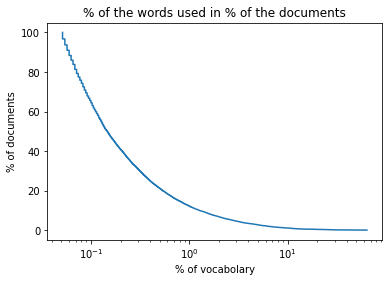

In [15]:
#print("Most common 50 counted by appearance in nr of reviews: ", cnt1.most_common(50))

vocab_size = len(cnt2)
sample_size = len(train_set)

x = [c/sample_size * 100 for (w, c) in cnt2.most_common()]
y = [c/vocab_size * 100 for c in range(1, vocab_size+1)]

fig, ax = plt.subplots()

ax.plot(x, y)
ax.set_title("% of the words used in % of the documents")
ax.set_xscale('log')
ax.set_xlabel("% of vocabolary")
ax.set_ylabel("% of documents")
plt.show()

From the graph above we see that after preprocessing the distribution of vocabulary in the documents are more smooth.

Below we see some random samples to check if the data is garbage or not. And we see it looks OK.

In [16]:
train_set_processed.sample(10)

,review,rate,label,rev_lens_raw,rev_lens_words,processed
9739,fascinating look at fascist italy and the peop...,10,1,279,50,fascinate look fascist italy people carve life...
32982,FBI Agents Mulder and Scully get assigned to p...,8,1,1784,298,fbi agent mulder scully get assign probe myste...
15073,As much as I like Japanese movies this one did...,3,0,928,168,much like japanese movie one cut movie suppose...
31243,This is absolutely the best none-animated fami...,10,1,268,47,absolutely best family film see quite back fir...
31756,I cannot believe how uneducated this movie is....,1,0,634,111,believe uneducated movie like watch police aca...
27970,question: how do you steal a scene from the ex...,8,1,671,111,question steal scene expert expert scene full ...
27600,Most people get the luxury of typing in the ti...,1,0,1635,291,people get luxury type title film find film wa...
20174,Hellraiser: Bloodline is where the sequel medi...,1,0,1241,214,hellraiser sequel mediocrity hellraiser series...
10428,"Worst DCOM I have seen. Ever. Well, maybe not ...",4,0,497,94,bad see ever well maybe bad smart house bad ac...
5823,Stu Ungar is considered by many to be the grea...,4,0,833,159,consider many great poker player time extraord...


#### 1.4.2 TF IDF Vectorizer class

TF-IDF stands for Term Frequency - Ineverse Document Frequency. TF is a number that shows frequency of term in the document, in this case in a particular reveiw. IDF is calculated by: $log(\frac{n}{1+DF})$ where N is number of documents in the Corpus, (here we use trainin set as corpus) and DF is document frequency, also number of documents that term appears in. If DF is high, the that must be a more common term, and TF of that term in the document has less weight.

TF-IDF values are ${TF \times IDF}$ or ${TF \times log(\frac{n}{1 + DF})}$ It takes into account both how much a term appears, and how unique is that term for that review.

There are different wasy to calculate TF-IDF values. I used this to avoud division by zero, as we add 1 in the divisor. In some websites they use 1 + n in the dividend to avoid negative values. But since we have removed all terms that apperas in more than 85 % of the documents, it's no term in the vocab appears in all documetns. So negative values of TF-IDF is not possible in this case.



When initializing the TfIdfVectorizer class I pass in dataframe (the training set) as argument. Then using two functions (prepare_idfs and prepare_vocab) it builds two dictionaries and saves them.

`self._vocab` is a dictionary where the keys are vocabulary taken from processed reviews in the training set. Also it's all the words used in the processed reviews in the training set. Values are used to determine which index TF-IDF values should be saved on. Each value in the `self._vocab` dictionary determines which index the TF-IDF value of a term in the review sohuld be be saved on.

`self._idfs` is a dictionary that has same keys as `self._vocab`. But it will contain the IDF values of each term, where IDF's are based on the training set, also based on who many times that term appears in the training set.


When we vectorize any text to put it into classification, we first preprocess it using functions in "TextPreprocessor", then we vectorize it using  `tf_idf_vectorize_all()`. That function accepts dataframe as argument. It will use .apply of the Pandas Dataframe and run `tf_idf_vectorize()` for each row in the 'processed'. Then we convert it to Numpy Array and return it.

`tf_idf_vectorize_all()` will return a Numpy array that has an array for each review, where size of each array is equal to size of `self._vocab` or vocabulary, with TF-IDF values that saved in the indexes that represent the words in the vocab (what index for what word is determined by using `self._vocab` dictionary).



Here's illustration with a small example:

For simple illustration let's say our corpus is very small and vocabulary has just 3 words. Then the `self._vocab` would be like:
{"hello": 0, "world": 1, "python": 2}.

`self._idfs` would be something similar, just it will contain IDF values. E.g. based on their frequencies, document size etc. it could be something like:

{"hello": 0, "world": 0, "python": 0.405}.

Here we assume the set has 8 documents. "hello" and "world" appears in 2 documents and "python" appears in one. So their values will be as shown above.

E.g. if the text is "hello hello world in python". We will ignore the word 'in' since it's not in the `self._vocab` dictionary.

We see the word "hello" exists in the `self._vocab` and has value '0 and its IDF value is 0 in `self._idfs`. It appears two times.
So we multiply 2 by 0, and save the value in index 0. The word "world" has the value '1' in the `self._vocab` dictionary, 0 in `self._idfs` dictionary, appears once in the document. So we multiply 1 by 0, and save the result in index 1. We repeat the same process for python. Then we return a Numpy array that looks like: [0, 0, 0.405]

The `self._idfs` and `self._vocab` is used in the code to make the vector generation more efficient, as we don't have to generate vocabs and IDF values each time.



In [17]:
# TF-IDF VECTORIZER CLASS

class TfIdfVectorizer:
    """
    This is a class for turning dataframe of text into TF-IDF vectors
      
    Attributes:
        idfs (dictionary): dictionary of words with their IDF values
        vocab (dictionary): dictionary of words with their index values as integers
    """
    
    def __init__(self, df):
        """
        The constructer of TfIDfVectorizer
        
        Parameters:
            df (Pands Dataframe): Dataframe with all the text that will be used to build 
            dictionary of IDF values and vocab dictionary
        """
        self._idfs = self.prepare_idfs(df)
        self._vocab = self.prepare_vocab(df)
    
    @property
    def idfs(self):
        """ Get IDFS"""
        return self._idfs
    
    @idfs.setter
    def idfs(self, idfs):
        """ Set IDFS """
        self._idfs = idfs
    
    @property
    def vocab(self):
        """ Get vocab"""
        return self._vocab
    
    @vocab.setter
    def vocab(self, vocab):
        """ Set vocab """
        self._vocab = vocab
    
    # Prepare and return vocab out of corpus
    def prepare_vocab(self, df):
        """
        Prepares the vocabulary to and returns a dictionary of vocabulary with increasing integer values.
        
        Parameters:
            df (Pandas Dataframe): Dataframe of text values to be used to generate vocabulary.
            The text values must be in a column named 'processed' in the dataframe.
        
        Returns:
            dict: A dictionary that maps each word from vocabulary to index value.
        """
        # Prepare the vocab
        self.vocab = set(" ".join(df['processed'].values).split())
        self.vocab = dict.fromkeys(self.vocab, 0)
        self.vocab.update((k, i) for i, k in enumerate(self.vocab))
        return self.vocab
    
    # Prepare and return idfs out of corpus
    def prepare_idfs(self, df):
        """
        Prepares the IDF values to and returns a dictionary of vocabulary with IDF values.
        
        Parameters:
            df (Pandas Dataframe): Dataframe of text values to be used to generate IDF values.
            The text values must be in a column named 'processed' in the dataframe.
        
        Returns:
            dict: A dictionary that maps each word from vocabulary to IDF value of that word.
        """
        # Counting how many reviews a word appears ins
        cnt = Counter()
        for text in df["processed"].values:
            for word in set(text.split()):
                cnt[word] += 1
        # Preparing the IDF vector
        size = len(df)
        self.idfs = dict()
        for w, c in cnt.items():
            self.idfs[w] = math.log((1+size) / (1 + c))
        return self.idfs


    # TF-IDF vectorize a single text, returning an np.array
    def tf_idf_vectorize(self, text):
        """
        Takes a text as argument and and returns a Numpy vector of TD-IDF values
        based on vocab and idfs attributes from that text.
        """
        
        freq_dist = FreqDist(text.split())
        vector = np.zeros(len(self.vocab))
        for w, c in freq_dist.items():
            if w in self.vocab:
                vector[self.vocab[w]] = c * self.idfs[w]
        return vector


    # One hot encode labels
    def one_hot_encode(self, label, nr_of_labels):
        """
        Takes integer and returns one-hot encoding numpy array of that
        """
        arr = np.zeros(nr_of_labels, dtype=int)
        arr[label] = 1
        return arr

    # Vectorize all in the dataset
    def tf_idf_vectorize_all(self, df):
        """
        Vectorizes all strings in a dataframe and returns numpy array of vectors based on idfs and vocab attributes.
        
        Parameters:
            df (Pandas Dataframe): All the strings must be saved in a column named 'processed'.
            
        Returns:
            numpy.ndarray: A numpy array which consists of vectors 
                of all text from all rows under 'processed' in the dataframe.
        """
        vectors = np.array(df['processed'].apply(lambda text: self.tf_idf_vectorize(text)).values.tolist())
        return vectors
    
    # Turn all labels into one hot encoded arrays
    def one_hot_encode_all(self, df, nr_of_labels):
        """
        Ane hot encodes all labels in a Pandas Dataframe and returns Numpy array
        
        Parameters:
            df (Pandas Dataframe): Labels must be saved in column named 'label'
            nr_of_labels: number of categories, classes or labels minus one.
            
        Returns:
            numpy.ndarray: A numpy array of all labels that are saved as one-hot encoded arrays each.
        """
        vector = np.array(df['label'].apply(lambda label: self.one_hot_encode(label, nr_of_labels)).values.tolist())
        return vector


    

#### 1.4.5 Vectorizing data sets using TF-IDF vectors

Here we instantiate TfIdfVector useing processed train set. We save the idfs and vocab in a variable for easier reference.

Then we generate Numpy arrays. X_train contains vectors representing reviews, Y_train contains labels in a numpy array.



In [18]:
# Get the IDF values and VOCAB vector
vectorizer = TfIdfVectorizer(train_set_processed)
idfs = vectorizer.idfs
vocab = vectorizer.vocab

In [19]:
# Vectorizing train set and test set
X_train = vectorizer.tf_idf_vectorize_all(train_set_processed)

X_test = vectorizer.tf_idf_vectorize_all(test_set_processed)

X_valid = vectorizer.tf_idf_vectorize_all(valid_set_processed)

Y_train = train_set_processed['label'].to_numpy()

Y_test = test_set_processed['label'].to_numpy()

Y_valid = valid_set_processed['label'].to_numpy()

Here we check if index of labels correspond to the vectors in the Numpy arrays. We print the vocab to see some of the words included. While it contains a couple of weird words, most of them looks OK. We see the length of vocab is ca 12k which is big enough.

In [278]:
# Check if labels fit with X values
index = random.randint(0, len(train_set))
print(Y_train[index])
print(train_set.loc[index, 'label'])

print(len(vocab))
print(str(vocab)[:1000])

0
0
12050
{'dental': 0, 'weed': 1, 'seek': 2, 'tremendously': 3, 'negotiate': 4, 'literary': 5, 'gackt': 6, 'hunk': 7, 'butch': 8, 'vulcan': 9, 'dis': 10, 'sidewalk': 11, 'haircut': 12, 'rebel': 13, 'investor': 14, 'hindu': 15, 'fbi': 16, 'impossible': 17, 'fulllength': 18, 'coach': 19, 'cross': 20, 'instance': 21, 'behind': 22, 'haul': 23, 'charity': 24, 'gunfight': 25, 'unfortunately': 26, 'elvis': 27, 'couldnt': 28, 'wall': 29, 'herein': 30, 'earth': 31, 'mushroom': 32, 'simultaneously': 33, 'ceo': 34, 'help': 35, 'unremarkable': 36, 'moore': 37, 'filler': 38, 'boo': 39, 'substitute': 40, 'fact': 41, 'therapy': 42, 'rightfully': 43, 'impromptu': 44, 'genitals': 45, 'command': 46, 'numbingly': 47, 'tightly': 48, 'perpetual': 49, 'unearth': 50, 'separately': 51, 'carlyle': 52, 'shuffle': 53, 'primetime': 54, 'newsreel': 55, 'coltrane': 56, 'pole': 57, 'blunder': 58, 'carole': 59, 'monday': 60, 'distinctive': 61, 'criminal': 62, 'suave': 63, 'donna': 64, 'fatigue': 65, 'illiterate': 66

## 2. Set up genetic algorithm

Genetic Algorithm is an algorithm that's inspired by evolution theory. Here we have a list of solutions that can be anything that keeps some data in some form of data-structures. They "mutate" and "reproduce" and new generations are produced. We choose the best chromosomes and eliminate bad ones. The goal is to come up with the best solution after some generations.

I built 3 classes to apply the genetic algorithm.
1. The classifier: It's a simple neural network. It takes vectors as input and classifies it, and calculates Cross Entropy Loss and accuracy.
2. The Chromosome: This is a class that essentially just keeps the weights and makes operations on the weights. In GA we are trying to optimize the weights. So it has some functions like mutation, crossover and assigning fitness.
3. GAEngine (Genetic Algorithm Engine): This class makes operations on the chromosomes at a higher lever. It has functions like choosing chromosomes to mutate, to do crossover, choosing what chromosomes to keep etc. and it has a function that runs the routine of the genetic algorithm training.

The structure where we use two seperate classes, GAEngine and Chromosome, is inspired from an earlier base code on GA assignment. On some guides online they use that structure too. It's very logical, convenient and easy to understand. Chromosome objects represents the "species" and GAEngine represents the "nature" in evolution theory.

While the GA training routine was put outside the GAEngine in the earlier GA assignment, I put it inside in a function here. That is to make the code more clean.

I could use both classifier and Chromosome as same class, since both keeps weights. But classifier keeps vocab and idfs. I didn't want to keep same data multiple places. Their functions are distinct, classifier is a classifier, but Chromosome just keeps and opreates on weights. So keeping them as distinct classes makes more sense and gives more clean structure.


### 2.1 Classifier
In the assignment text they mention using decision tree. I tried to build one, but I have not much experience with decision trees. There are other classifiers too. I haven't any experience in most of them, just a little familiar with Neural Network thus this is what I did choose.

Too simple architecture fails to make prediction. I tried with simple architecture and it was almost untrainable. Too complicated architecture (too many nodes, too much hidden layers) causes overfitting and it's very slow in training and prediction. After experimenting with different models, the model I decided is this:

Input is as long as length of the vocab, which is 1250.

Then a hidden layer of 16 nodes, using ReLU as activation function.
Then a hidden layer of 8 nodes, using ReLU as activation function.
Then using one more hidden layer of 2 nodes. No special activation function is used, it's just linear.
Then at the end I use "SoftMax" to get predictions as output.

Number of layers can't be set dynamically, but number of hidden nodes can be set dynamically while instantiating the classifier.

The classifier returns both "Cross Entropy Loss" and "accuracy".


In [21]:
class Classifier:
    """
    This is a simple 3 layer neural network classifier.
    
    It has 2 hidden layers. Output has two nodes and uses softmax at the end.
    It's attributes are idfs that show IDF values, vocab that have vocab values.
    How many nodes in the input is determined by the attribute in_vector.
    Other attributes are 3 Numpy matrices of weights and 3 Numpy arrays of biases.
    """
    def __init__(self, idfs, vocab):
        """
        The constructor for Classifier class.
        
        Parameters:
            idfs (dict): a dictionary that maps words and IDF values
            vocab (dict): a dictionary that maps words and integer values (where in the vector the word is presented)
        """
        
        self.idfs = idfs
        self.vocab = vocab
        self.ws_1 = 0
        self.ws_2 = 0
        self.ws_3 = 0
        self.bias_1 = 0
        self.bias_2 = 0
        self.bias_3 = 0
        self.hn_1 = 0
        self.hn_2 = 0
        self.in_vector = 0

    # Initializing weights
    def init_weights(self):
        """
        Initializing weights and biases and returning them.
        
        Returns:
            (numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray): Weights and biases
                for the neural net
        """
        self.ws_1 = np.random.rand(self.in_vector, self.hn_1) - 0.5
        self.ws_2 = np.random.rand(self.hn_1, self.hn_2) - 0.5
        self.ws_3 = np.random.rand(self.hn_2, 2) - 0.5
        self.bias_1 = np.random.rand(self.hn_1) - 0.5
        self.bias_2 = np.random.rand(self.hn_2) - 0.5
        self.bias_3 = np.random.rand(2) - 0.5
        return self.ws_1, self.ws_2, self.ws_3, self.bias_1, self.bias_2, self.bias_3
        
    def set_weights(self, ws_1, ws_2, ws_3, bias_1, bias_2, bias_3):
        """
        Setting weights and biases for the neural net.
        
        Parameters:
            ws_1 (numpy matrice / array ): weights for first layer.
            ws_2 (numpy matrice / array ): weights for second layer.
            ws_3 (numpy matrice / array ): weights for thrid layer.
            bias_1 (numpy array ): bias for first layer.
            bias_2 (numpy array ): bias for second layer.
            bias_3 (numpy array ): bias for third layer.
        """
        self.ws_1 = ws_1
        self.ws_2 = ws_2
        self.ws_3 = ws_3
        self.bias_1 = bias_1
        self.bias_2 = bias_2
        self.bias_3 = bias_3
    
    def set_hidden_nodes(self, in_vector, hn_1, hn_2):
        """
        Setting how many nodes in input layer and on hidden layers.
        
        Parameters:
            in_vector (int): nr of hidden nodes
            hn_1 (int): nr of hidden nodes on first hidden layer
            hn_2 (int): nr of hidden nodes on second hidden layer
        """
        self.hn_1 = hn_1
        self.hn_2 = hn_2
        self.in_vector = in_vector

    def relu(self, x):
        """
        Applies ReLU activating function.
        """
        return (x > 0) * x
    
    def relu_grad(self, x):
        """
        Applies ReLU gradient function and returns its result.
        """
        return x > 0
    
    def sigmoid(self, x):
        """
        Applies Sigmoid function and returns its result.
        """
        return special.expit(x)
    
    def sigmoid_grad(self, x):
        """
        Applies Sigmoid gradient function and returns its result.
        """
        return self.sigmoid(x)*(1 - self.sigmoid(x))
    
    def softmax(self, x):
        """
        Applies Softmax function and returns its result.
        """
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()
        

    def cross_entropy(self, p, y):
        """
        A function that calculates Cross Entropy Loss and returns the result
        """
        return (-np.nan_to_num(np.eye(2)[y]*np.log(p))).mean() * 2
    
    def predict(self, x, get_all=False):
        """
        Forward pass, prediction class of data.
        
        Parameters:
            x (Numpy array): the vector preresenting the data.
            get_all (boolean): 
                Set True if you want to return output of all layers.
                Set false if you only want to return output of last layer.
        Returns:
            numpy.ndarray: output of last layer 
            OR
            (numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray): output of all layers.
        """
        #forward pass/prediction
        layer_1 = self.relu(x.dot(self.ws_1))
        layer_2 = self.relu(layer_1.dot(self.ws_2))
        layer_3 = layer_2.dot(self.ws_3)
        layer_out = self.softmax(layer_3)
        if get_all:
            return layer_out, layer_3, layer_2, layer_1
        else:
            return layer_out
    
    def get_accuracy(self, y, p):
        """
        Function that calculates accuracy after predicting all dataset
        """

        acc = np.sum((y == np.argmax(p, axis=1))) / len(y)
        return acc
    

    def predict_whole_set(self, x, y):
        """
        Makes prediction on whole dataset and returns CEL, last layout outputs and accuracy.
        
        Parameters:
            x (Numpy matrice): A Numpy matrice that contains vectors.
            y (Numpy array): a Numpy array that containts corresponding label values.
            
        Returns:
            numpy.ndarray: mean Cross Entropy Loss of each prediction.
            numpy.ndarray: output of last layout for each prediction.
            float: Accuracy of the prediction of the data set.
        """
        output = np.apply_along_axis(self.predict, 1, x)
        cel = self.cross_entropy(output, y)
        acc = self.get_accuracy(y, output)
        return cel, output, acc
    

        

Here we initialize and test our classifier to see how it predicts, if it works as expected or not.

In [22]:
# Initialize classifier
classifier = Classifier(idfs, vocab)

In [23]:
classifier.set_hidden_nodes(len(vocab), 16, 8)
classifier.init_weights()
cel_pre, output, acc_pre = classifier.predict_whole_set(X_valid, Y_valid)
print("Cross Entropy Loss before training", cel_pre)
print("Accuracy before training", acc_pre)

6.422734799603507
0.5
[[9.99995596e-01 4.40379506e-06]
 [9.99989505e-01 1.04947816e-05]
 [9.99983909e-01 1.60913010e-05]
 ...
 [9.94659878e-01 5.34012166e-03]
 [9.99873338e-01 1.26661609e-04]
 [9.99988110e-01 1.18898215e-05]]
(12050, 16) (16, 8) (8, 2)
2


### 2.2 Chromosome
This is the Chromosome. Chromosome keeps the weights and has some methods for mutation, cross.over and fitness calculation

I have written own operator functions like`__eq__`. The comparisons will be made based on value of `self.fitness`. In the GAEngine I do compare the fitness values and sort the lists, so rather than calling lambda each time I cal max() or sorte(), I did implement those functions to make the code more clean and robust.

The Chromosome has three essential functions:
1. Assign fitness. This uses the classifier class above. It is based on accuracy after predicting the data on validation set. The goal is to increase the accuracy as much as possible.
2. Cross over: it accepts another chromosome as parameter. New weights are produced from calculations which made based on weight values of both chromosomes (self and other). Then a new chromosome is iniitalized and returned. It's as parents give offspring to a child where childs genes are combination of parent's genes. But in this algorithm the Chromosomes has no genders, so anyone can make offspring from anyone.
3. Mutation: here we make som random changes on the weights of the Chromosome.



I have tried 3 different cross-over methods:
1. Single point: divide weights in two from a random index. Get the first half from first parent and second half from other parent.
2. Multiple point: swapping multiple weight values between two chromosomes and produce offspring from them

Assume we have two genes:
[0.54,0.24,0.67,1.45, 0.55]
[0.37,0.98,0,79,0.45, 0.13]

Single point split can produce something like: [0.54, 0.24, 0.79, 0.45, 0.13].

Multiple point can produce something like: [0.54, 0.98, 0,67, 0.45, 0.13]

3. Uniform: New weight values that's randomly choosed between parents' weight values pluss / minus a constant 'r'. Also if weight 1_1 from parent is 0.5, weight 1_1 from other parent is 0.8. If the constant 'r' has value 0.1. Then the the weight 1_1 of the offspring will be something between 0.4 and 0.9.

And I have tried 3 different mutations:
1. Choose random weights and biases, and increment or decrement their value by a range between 0 and 0.1.
2. Assign random value between -1 and 1 to all weights and biases. That is more like resetting all values of the Chromosome.
3. Choose some random weights and bises, assign a new value to them that's between -1 and 1.


The other methods are read in the code but outcommented. Rather than removing them I kept them as comments so one can experiment with them later.



In [267]:
class Chromosome:
    """
    This is a class Chromosome to use in Genetic Algorithm.
    
    It keeps weights and biases for a simple neural network.
    It's attributes are weights, biases and fitness. Fitness is 
    measured by accuracy of the prediction.
    """
    
    def __init__(self, ws_1, ws_2, ws_3, bias_1, bias_2, bias_3):
        """
        The constructor for Chromosome class.
        
        Parameters:
            ws_1 (Numpy array / matrice): weights for first layer
            ws_2 (Numpy array / matrice): weights for second layer
            ws_3 (Numpy array / matrice): weights for third layer
            bias_1 (Numpy array): bias for first layer
            bias_2 (Numpy array): bias for second layer
            bias_3 (Numpy array): bias for third layer
        """
        self._fitness = 0
        self._ws_1 = ws_1
        self._ws_2 = ws_2
        self._ws_3 = ws_3
        self._bias_1 = bias_1
        self._bias_2 = bias_2
        self._bias_3 = bias_3
    
    # Getters and setters
    @property
    def ws_1(self):
        """
        Get weights for first layer.
        """
        return self._ws_1
    
    @ws_1.setter
    def ws_1(self, value):
        """
        Set weights for first layer.
        """
        self._ws_1 = value
    
    @property
    def ws_2(self):
        """
        Get weights for second layer.
        """
        return self._ws_2
    
    @ws_2.setter
    def ws_2(self, value):
        """
        Set weights for second layer.
        """
        self._ws_2 = value
    
    @property
    def ws_3(self):
        """
        Get weights for third layer.
        """
        return self._ws_3
    
    @ws_3.setter
    def ws_3(self, value):
        """
        Set weights for third layer.
        """
        self._ws_3 = value
    
    @property
    def bias_1(self):
        """
        Get bias for first layer.
        """
        return self._bias_1
    
    @bias_1.setter
    def bias_1(self, value):
        """
        Set bias for first layer.
        """
        self._bias_1 = value
    
    @property
    def bias_2(self):
        """
        Get bias for second layer.
        """
        return self._bias_2
    
    @bias_2.setter
    def bias_2(self, value):
        """
        Set bias for second layer.
        """
        self._bias_2 = value
    
    @property
    def bias_3(self):
        """
        Get bias for third layer.
        """
        return self._bias_3
    
    @bias_3.setter
    def bias_3(self, value):
        """
        Set bias for third layer.
        """
        self._bias_3 = value
    
    @property
    def fitness(self):
        """
        Get fitness of the chromosome.
        """
        return self._fitness
    
    @fitness.setter
    def fitness(self, value):
        """
        Set fitness of the chromosome.
        """
        self._fitness = value
    
    def __lt__(self, other):
        """
        Check if fitness is less than other.
        """
        return self.fitness < other.fitness

    def __le__(self, other):
        """
        Check if fitness is less than or equal to other.
        """
        return self.fitness <= other.fitness
    
    def __eq__(self, other):
        """
        Check if fitness is equal to other.
        """
        return self.fitness == other.fitness
    
    def __ne__(self, other):
        """
        Check if fitness is not equal to other.
        """
        return self.fitness != other.fitness
    
    def __ge__(self, other):
        """
        Check if fitness is greater than or equal to other.
        """
        return self.fitness >= other.fitness
    
    def __gt__(self, other):
        """
        Check if fitness is greater than other.
        """
        return self.fitness > other.fitness
    
    def assign_fitness(self, classifier, x, y):
        """
        Function to assign / update fitness of the chromosome.
        
        Parameters:
            classifier (Classifier): Classifier class to test weights on.
            x (Numpy matrice): data set vectors
            y (Numpy array): data set labels
        """
        classifier.set_weights(self.ws_1, self.ws_2, self.ws_3,
                               self.bias_1, self.bias_2, self.bias_3)
        loss, _, acc = classifier.predict_whole_set(x, y)
        self.fitness = acc #0 if loss <= 0 or loss == float('inf') else -math.log(1 / loss)
    
    # produce a new offspring from 2 parents
    def crossover(self, other):
        """
        Function to do crossover with another chromosome returning new chromosome.
        
        Parameters:
            other (Chromosome): the chromosome to do cross-over with.
        
        Returns:
            Chromosome: new chromosome object.
        """
        r = 0.01
        
        ## SINGLE POINT
#         i = random.randint(0, len(self.ws_1) - 1) 
#         ws_1_1 = np.append(self.ws_1[i:], other.ws_1[:i], axis=0)
#         ws_1_2 = np.append(self.ws_1[:i], other.ws_1[i:], axis=0)
        
#         i = random.randint(0, len(self.ws_2) - 1) 
#         ws_2_1 = np.append(self.ws_2[i:], other.ws_2[:i], axis=0)
#         ws_2_2 = np.append(self.ws_2[:i], other.ws_2[i:], axis=0)
        
#         i = random.randint(0, len(self.ws_3) - 1) 
#         ws_3_1 = np.append(self.ws_3[i:], other.ws_3[:i], axis=0)
#         ws_3_2 = np.append(self.ws_3[:i], other.ws_3[i:], axis=0)
        
#         i = random.randint(0, len(self.bias_1) - 1) 
#         bias_1_1 = np.append(self.bias_1[i:], other.bias_1[:i], axis=0)
#         bias_1_2 = np.append(self.bias_1[:i], other.bias_1[i:], axis=0)
        
        
#         i = random.randint(0, len(self.bias_2) - 1) 
#         bias_2_1 = np.append(self.bias_2[i:], other.bias_2[:i], axis=0)
#         bias_2_2 = np.append(self.bias_2[:i], other.bias_2[i:], axis=0)
        
#         i = random.randint(0, len(self.bias_3) - 1) 
#         bias_3_1 = np.append(self.bias_3[i:], other.bias_3[:i], axis=0)
#         bias_3_2 = np.append(self.bias_3[:i], other.bias_3[i:], axis=0)
        
        
        
         ## MULTI POINT
#         ws_1 = self.ws_1.copy()
#         n = int(self.ws_1.size / 2 + 1)
#         index1 = np.random.choice(ws_1.shape[0], n, replace=True)
#         index2 = np.random.choice(ws_1.shape[1], n, replace=True)
#         ws_1[index1, index2] = other.ws_1[index1, index2]
        
#         self.ws_1[index1, index2]
        
#         ws_2 = self.ws_2.copy()
#         n = int(self.ws_2.size / 2 + 1)
#         index1 = np.random.choice(ws_2.shape[0], n, replace=True)
#         index2 = np.random.choice(ws_2.shape[1], n, replace=True)
#         ws_2[index1, index2] = other.ws_2[index1, index2]
        
#         ws_3 = self.ws_3.copy()
#         n = int(self.ws_3.size / 2 + 1)
#         index1 = np.random.choice(ws_3.shape[0], n, replace=True)
#         index2 = np.random.choice(ws_3.shape[1], n, replace=True)
#         ws_3[index1, index2] = other.ws_3[index1, index2]
        
#         bias_1 = self.bias_1.copy()
#         n = int(self.bias_1.size / 2 + 1)
#         index1 = random.sample(range(bias_1.size), n)
#         bias_1[index1] = other.bias_1[index1]
        
#         bias_2 = self.bias_2.copy()
#         n = int(self.bias_2.size / 2 + 1)
#         index1 = random.sample(range(bias_2.size), n)
#         bias_2[index1] = other.bias_2[index1]
        
#         bias_3 = self.bias_3.copy()
#         n = int(self.bias_3.size / 2 + 1)
#         index1 = random.sample(range(bias_3.size), n)
#         bias_3[index1] = other.bias_1[index1]
        
        
        
#         ## RANDOM UNIFORM
        min_mat_1 = np.minimum(self.ws_1, other.ws_1)
        max_mat_1 = np.maximum(self.ws_1, other.ws_1)
        min_mat_2 = np.minimum(self.ws_2, other.ws_2)
        max_mat_2 = np.maximum(self.ws_2, other.ws_2)
        min_mat_3 = np.minimum(self.ws_3, other.ws_3)
        max_mat_3 = np.maximum(self.ws_3, other.ws_3)
        min_mat_4 = np.minimum(self.bias_1, other.bias_1)
        max_mat_4 = np.maximum(self.bias_1, other.bias_1)
        min_mat_5 = np.minimum(self.bias_2, other.bias_2)
        max_mat_5 = np.maximum(self.bias_2, other.bias_2)
        min_mat_6 = np.minimum(self.bias_3, other.bias_3)
        max_mat_6 = np.maximum(self.bias_3, other.bias_3)
        
        ws_1 = np.random.uniform(min_mat_1-r, max_mat_1+r)
        ws_2 = np.random.uniform(min_mat_2-r, max_mat_2+r)
        ws_3 = np.random.uniform(min_mat_3-r, max_mat_3+r)
        bias_1 = np.random.uniform(min_mat_4-r, max_mat_4+r)
        bias_2 = np.random.uniform(min_mat_5-r, max_mat_5+r)
        bias_3 = np.random.uniform(min_mat_6-r, max_mat_6+r)
        
        offspring1 = Chromosome(ws_1, ws_2, ws_3, bias_1, bias_2, bias_3)
#         offspring1 = Chromosome(ws_1_1, ws_2_1, ws_3_1, bias_1_1, bias_2_1, bias_3_1)
#         offspring2 = Chromosome(ws_1_2, ws_2_2, ws_3_2, bias_1_2, bias_2_2, bias_3_2)
        return offspring1#, offspring2

    # mutate the individual
    def mutate(self):
        """
        Function for mutation, changint the weights and bias value of the chromosome.
        """
        ### Change random weights
        n = np.random.randint(1, int(self.ws_1.size / 4))
        index1 = np.random.choice(self.ws_1.shape[0], n, replace=True)
        index2 = np.random.choice(self.ws_1.shape[1], n, replace=True)
        self.ws_1[index1, index2] = np.random.uniform(-1,1, n)

        n = np.random.randint(1, int(self.ws_2.size / 4))
        index1 = np.random.choice(self.ws_2.shape[0], n, replace=True)
        index2 = np.random.choice(self.ws_2.shape[1], n, replace=True)
        self.ws_2[index1, index2] = np.random.uniform(-1,1, n)
        
        n = np.random.randint(1, int(self.ws_3.size / 4))
        index1 = np.random.choice(self.ws_3.shape[0], n, replace=True)
        index2 = np.random.choice(self.ws_3.shape[1], n, replace=True)
        self.ws_3[index1, index2] = np.random.uniform(-1,1, n)
        
        n = np.random.randint(1, int(self.bias_1.size / 4))
        index1 = random.sample(range(self.bias_1.size ), n)
        self.bias_1[index1] = np.random.uniform(-1, 1, n)
        
        n = np.random.randint(1, int(self.bias_2.size / 2))
        index1 = random.sample(range(self.bias_2.size ), n)
        self.bias_2[index1] = np.random.uniform(-1, 1, n)
        
        n = np.random.randint(1, int(self.bias_3.size + 1))
        index1 = random.sample(range(self.bias_3.size ), n)
        self.bias_3[index1] = np.random.uniform(-1, 1, n)
        
        
        ## INCREMENTING DECREMENTING
#         self.ws_1 = self.ws_1 + np.random.uniform(-0.1, 0.1, size=self.ws_1.shape)*np.random.randint(0, 2, size=self.ws_1.shape)
#         self.ws_2 = self.ws_2 + np.random.uniform(-0.1, 0.1, size=self.ws_2.shape)*np.random.randint(0, 2, size=self.ws_2.shape)
#         self.ws_3 = self.ws_3 + np.random.uniform(-0.1, 0.1, size=self.ws_3.shape)*np.random.randint(0, 2, size=self.ws_3.shape)
#         self.bias_1 = self.bias_1 + np.random.uniform(-0.1, 0.1, size=self.bias_1.shape)*np.random.randint(0, 2, size=self.bias_1.shape)
#         self.bias_2 = self.bias_2 + np.random.uniform(-0.1, 0.1, size=self.bias_2.shape)*np.random.randint(0, 2, size=self.bias_2.shape)
#         self.bias_3 = self.bias_3 + np.random.uniform(-0.1, 0.1, size=self.bias_3.shape)*np.random.randint(0, 2, size=self.bias_3.shape)

        ## RANDOM UNIFORM
#         self.ws_1 = np.random.uniform(-1, 1, size=self.ws_1.shape)
#         self.ws_2 = np.random.uniform(-1, 1, size=self.ws_2.shape)
#         self.ws_3 = np.random.uniform(-1, 1, size=self.ws_3.shape)
#         self.bias_1 = np.random.uniform(-1, 1, size=self.bias_1.shape)
#         self.bias_2 = np.random.uniform(-1, 1, size=self.bias_2.shape)
#         self.bias_3 = np.random.uniform(-1, 1, size=self.bias_3.shape)
        return
    

    



### 2.3 Genetic Algorithm Engine

Here I have divided the chromosome in two groups: elite and population.
Elite contains the population with highest fitness. This is maybe not conventional way of GA.
One way conventional way is to keep the whole population in one place, we carry X % of the best to next generations on each generation.

But there are two reasons I wanted to keep elite at separate list:
* To make sure if we find a very fit chromosome we don't lose it again because of cross overs or mutations. We keep them and carry them to next generations.
* Since we know the fitness values of the chromosomes in elite, we don't run assign_fitness() function. This speeds the algorithm up. Function to assign fitness is done by prediction the whole validation set consisting of 7,500 datas. That is a heavy process. Reducing number of times we assign fitness speeds the algorithm up.
* We could keep both in same list and make divisions. But it's more robust to keep them in separate list, and the code is easier to handle.


And we make the mutations first. We make mutations on the least fit chromosomes. We don't want to mutate highest fit chromosomes. How many to mutate is also passed as a parameter. After mutations we determine the mutated chromosomes new fitness values and update elite list again.

In the cross-over I use something similar to roulette wheel. How much of the crossover will be from elite will be passed as a parameter. 
Based on that value, I produce M number of offsprings only from the elites (chosen randomly). Elites are the list of most fit chromosomes. How many to keep in elites is also passed as a parmater to training function.

And I produce N number of offsprings from the chromosomes randomly chosen from population. But here the random choice is weighted one, also it's higher probabilty to choose chromosomes with higher fitness values. After all the cross overs the old population is thrown out and new generation is produced from the offsprings. The number of the offsprings is equal to the number of the population to avoid decrease or increase in the population. Since we keep the most fit ones in the elite list, we don't lose winners by replacing the old generation with the new geneartion.

After the cross-overs it determines the fitness values of the new population and update the elite list again.





In [213]:
class GAEngine:
    """
    This is a class that runs Genetic Algorithm on higher level, operates on Chromosome objects.
      
    Attributes:
        population (list): list of chromosomes.
        generations (int): number of generations to run.
        classifier (Classifier): the classifier to test the chromosomes (weights) on.
        elite (list): a list of chromosomes with highest fitness so far.
        nr_of_elites (int): how many elite chromosomes to keep in elite list.
        x: data set to use when testing chromsomes with the classifier while assigning  fitness.
        y: labels to use when testing chromsomes with the classifier while assigning  fitness.
    """
    def __init__(self, classifier):
        """
        The constructor for GAEngine class
        
        Parameters:
            classifier (Classifier): the classifier to use to test the chromosomes (weights) on.
        """
        
        self._population = []
        self._generations = 0
        self._classifier = classifier
        self._elite = []
        self.nr_of_elites = 0
        self._x = []
        self._y = []

      
    @property
    def generations(self):
        """
        Get number of generations.
        """
        return self._generations
    
    @generations.setter
    def generations(self, g):
        """
        Set number of generations.
        """
        self._generations = g
    
    @property
    def population(self):
        """
        Get population.
        """
        return self._population
    
    @population.setter
    def population(self, p):
        """
        Set population.
        """
        self._population = p
    
    @property
    def elite(self):
        """
        Get elite.
        """
        return self._elite
    
    @elite.setter
    def elite(self, e):
        """
        Set elite.
        """
        self._elite = e
    
    @property
    def classifier(self):
        """
        Get classifier.
        """
        return self._classifier
    
    @classifier.setter
    def classifier(self, cl):
        """
        Set classifier.
        """
        self._classifier = cl
        
    @property
    def x(self):
        """
        Get x (dataset vectors to test chromosomes on).
        """
        return self._x
    
    @x.setter
    def x(self, x):
        """
        Set x (dataset vectors to test chromosomes on).
        """
        self._x = x

    @property
    def y(self):
        """
        Get y (dataset labels to test chromosomes on).
        """
        return self._y
    
    @y.setter
    def y(self, y):
        """
        Set y (dataset labels to test chromosomes on).
        """
        self._y = y
    
    def make_initial_population(self, population_size):
        """
        Making the initial population with random weight and bias values
        
        Parameters:
            population_size: number of chromosomes to start with
        """
        for i in range(population_size):
            ws_1, ws_2, ws_3, bias_1, bias_2, bias_3 = self.classifier.init_weights()
            self.population.append(Chromosome(ws_1, ws_2, ws_3, bias_1, bias_2, bias_3))
    
    # selection code goes here...
    def do_crossover(self, elite_crossover_rate):
        """
        Function to do crossover between chromosomes
        
        Parameters:
            elite_crossover_rate: the rate of population size to produce offsprings from chromosomes in elite list.
            
        Produces new chromosomes for new generation, as many as size of population list. 
        Based on elite_cross_over rate some of the offsprings are produced from randomly chosen chromosomes
        from elite list, others are produced from randomly chosen chromosomes from population list, but in this case
        it's weighted random selection.
        """
        
        new_population_size = int(len(self.population) / 1)
        
                
        # Here we combine elitism selection with roulette wheel
        # We carry some of the most fit over to the next generation.
        # We do cross over with both the elite and other population
        # Then we use roulette wheel because we want diversity too.
        # We want diversity because it's hard to predict optimal weights
        
        no_of_elite_crossovers = int(elite_crossover_rate * new_population_size)
        
        other_offspring = new_population_size - no_of_elite_crossovers

        new_generation = list()
        
        # Offsprings from the elite
        for i in range(no_of_elite_crossovers):
            parent1, parent2 = random.choices(self.elite, k=2)
            offspring1 = parent1.crossover(parent2)
            new_generation.append(offspring1)
            #new_generation.append(offspring2)
        
        # Weighted random choice
        fitness_values = [x.fitness for x in self.population]
        
        # Offsprings from other population
        for i in range(other_offspring):
            parent1, parent2 = random.choices(self.population, weights=fitness_values, k=2)
            offspring1 = parent1.crossover(parent2)
            new_generation.append(offspring1)
            #new_generation.append(offspring2)
            
        
        # The population is the new generation
        self.population = new_generation
        return
    
    
    def do_mutation(self, no_of_mutation):
        """
        Function to do mutation on Chromosomes with lowest fitness.
        
        After mutation the fitness values of the mutated chromosomes are updated again.
        
        Parameters:
            no_of_mutation: number of chromosomes to mutate.
            x: dataset to test run
        """
        for i in range(no_of_mutation):
            ch = np.random.choice(self.population)
            ch.mutate()
            ch.assign_fitness(self.classifier, self.x, self.y)
        self.population = sorted(self.population, reverse=True)
    
    
    # fitness calculation goes here...
    def assign_fitness(self):
        """
        Function to assign / update fitness to all chromosomes.
        """
        for ch in self.population:
            ch.assign_fitness(self.classifier, self.x, self.y)
        self.population = sorted(self.population, reverse=True)
        return
    
    
    
    def update_elite(self):
        """
        Function to update elite list.
        """
        if len(self.elite) == 0:
            self.elite = self.population[-self.nr_of_elites:]
            self.elite = sorted(self.elite, reverse=True)
            return
        i = 0
        j = 0
        while i < self.nr_of_elites and j < len(self.population):
            if self.elite[i] < self.population[j]:
                self.elite[i] = self.population[j]
                i += 1
                j += 1
            else:
                i += 1
        
        self.elite = sorted(self.elite, reverse=True)

    
    def get_best_chromosome(self):
        """
        Function to get best elite from elite list.
        """
        return max(self.elite)
    
    
    
    # TRAINING ROUTINE
    def training_routine(self, init_population, nr_of_generations, 
                        nr_of_mutation, nr_of_elites, elite_crossover_rate, x, y):
        """
        Function implementing Genetic Algorithm on higher level, the optimization routine.
        
        Parameters:
            init_population (int): size of inital population
            nr_of_generations (int): number of generations to run this algorithm on
            nr_of_mutation (int): number of chromosomes to apply mutation on
            nr_of_elites (int): number of chromosomes to keep in elite list
            elite_crossover_rate (float): Rate of the offsprings that will be produced from
                chromosomes in elite list.
            x: data set to use when testing chromsomes with the classifier while assigning  fitness.
            y: labels to use when testing chromsomes with the classifier while assigning  fitness.
        
        Returns:
            list: Fitness value of the best chromosome on each generation.
            Chromosome: Best chromosome after all the generations.
        """
        
        
        self.make_initial_population(init_population)
        self.generations = nr_of_generations
        self.nr_of_elites = nr_of_elites
        self.x = x
        self.y = y
        
        fits = list()


        for i in range(self.generations):
            self.assign_fitness()
            self.update_elite()
            fits.append(self.elite[0].fitness)
            
            self.do_mutation(nr_of_mutation)
            self.update_elite()
            
            self.do_crossover(elite_crossover_rate)
            
            

        # Assign fitness last time before getting the best chromosome
        self.assign_fitness()
        self.update_elite()
        fits.append(self.get_best_chromosome().fitness)
        return self.get_best_chromosome(), fits


In [214]:
print(Y_valid)

[0 0 0 ... 0 1 1]


### 2.4 Optimizing classifier with Genetic Algorithm

Here I just run the training_routine function of the GAEngine.

It has following parameters:
* init_population: The population to start with.
* nr_of_generations: how many generations to run this
* nr_of_mutation: how many mutations
* nr_of_elites: how many to keep in self.elite.
* elite_crossover_rate: the offspring rate is constant (equal to size of population). This determines how much of that offspring should be produced from chromosomes in self.elite, and how much from self.population.

How accurate the classifier predicts (preprocessed and vectorized) reviews in the validation set is used as fitness value of the chromosomes. Also fitness value is same as prediction accuracy.



In [215]:
%%time
# Here I run the GA engine
classifier = Classifier(idfs, vocab)
classifier.set_hidden_nodes(len(vocab), 16, 8)

ga = GAEngine(classifier)

init_population = 100
nr_of_generations = 100
nr_of_mutation = 8
nr_of_elites = 30
elite_crossover_rate = 0.9

ch, cels = ga.training_routine(init_population, 
                               nr_of_generations, 
                               nr_of_mutation,
                               nr_of_elites, 
                               elite_crossover_rate, 
                               X_valid, Y_valid)

Wall time: 1h 21min 16s


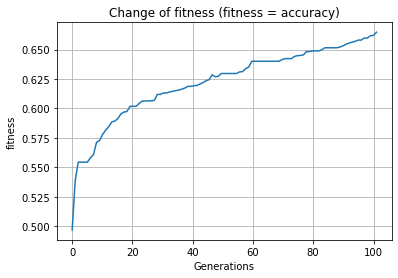

In [252]:
# Plotting increase of fitness in training
x_ga = np.linspace(0, len(cels), len(cels))
fig, ax = plt.subplots(1, 1)
ax.plot(x_ga, cels, label='fitness')

plt.xlabel("Generations")
plt.ylabel("fitness")
plt.title("Change of fitness (fitness = accuracy)")

plt.grid()
plt.show()


## 3. Validation

### 3.1 Testing the trained weights from GA
Here we use the weights of the most fit chromosome after the optimization using GA in our classifier.
We classify the whole testing set and print the results both in terms of accuracy and CEL to see how it performs.

In [268]:
classifier.set_weights(ch.ws_1, ch.ws_2, ch.ws_3, ch.bias_1, ch.bias_2, ch.bias_3)
cel_post_GA, output_post_GA, acc_post_GA = classifier.predict_whole_set(X_test, Y_test)
cel_post_GA_valid, output_post_GA_valid, acc_post_GA_valid = classifier.predict_whole_set(X_valid, Y_valid)


In [266]:
print("Accuracy before training: ", acc_pre)
print("Accuracy after training: ", acc_post_GA)
print("CEL before training", cel_pre)
print("CEL after training", cel_post_GA)

Accuracy before training:  0.5
Accuracy after training:  0.5893333333333334
CEL before training 6.422734799603507
CEL after training 0.7343883764310389


### 3.2 PyTorch test

The assignment asks to build own classifier in Python without using libraries like PyTorch or Tensorflow. Thus I build my own classifier class as seen above.

But I wanted to compare training weights using GA vs using SDG. I didn't want to build SDG training algorithm without libraries since the assignment doesn't ask for building a SDG trainer. Thus to make the comparison I used PyTorch here.

Below is the "training with SDG" routine using PyTorch, and the results shown in a plot.

In [225]:
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim

#### 3.2.1 Testing and training routines

In [231]:
# Training function

def training(num_epochs, model, optimizer, criterion, train_loader, valid_loader, vocab_length):
    results = list()
    accuracies = list()
    valid_results = list()
    valid_accuracies = list()

    #model.float()
    for ep in range(num_epochs):
        running_loss = 0
        valid_loss = 0
        total = 0
        correct = 0
        total_valid = 0
        correct_valid = 0
        model.train() # Set model into training mode
        for batch in train_loader:
            # We extract the images and labels from the batch
            vector = batch[:, :vocab_length]
            labels = batch[:, vocab_length]
            labels = torch.tensor(labels, dtype=torch.long)
            # This will prevent the gradient descents from the previous batches to accumulate. Without this the weight will get updated with the sum of
            # all previos gradient descents, instead of the gradient descents on the current batch.
            optimizer.zero_grad() 
            output = model(vector) # prediction / output from the model

            loss = criterion(output, labels)  # We calculate the loss here
            loss.backward() # Computes the derivative of the loss using backpropagation.
            optimizer.step() # We update the weights

            running_loss += loss.item() # Sum the loss here
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        else:
            results.append(running_loss / len(train_loader))  # We append the mean loss into a list
            accuracies.append(correct / total)
    
        # Validation part
        model.eval()
        with torch.no_grad(): # This will prevent calculation of gradient descents
            for batch in valid_loader:
                vector = batch[:, :vocab_length]
                labels = batch[:, vocab_length]
                valid_output = model(vector) # Prediciton
                loss = criterion(valid_output, labels.long()) # Calculation of loss
                valid_loss += loss.item() # Sum the loss

                _, predicted = torch.max(valid_output.data, 1)
                total_valid += labels.size(0)
                correct_valid += (predicted == labels).sum().item()
            else:
                valid_results.append(valid_loss / len(valid_loader)) # Here we calculate the mean loss
                valid_accuracies.append(correct_valid / total_valid)
    return results, accuracies, valid_results, valid_accuracies

In [232]:
# testing function

def testing(model, criterion, test_loader, vocab_length):
    model.eval() # Set model into evaluation model
    test_loss = 0
    total = 0
    correct = 0
    with torch.no_grad(): # This will prevent calculation of gradient descents
        for batch in test_loader:
            vector = batch[:, :vocab_length]
            labels = batch[:, vocab_length]
            valid_output = model(vector) # Prediciton
            loss = criterion(valid_output, labels.long()) # Calculation of loss
            test_loss += loss.item() # Sum the loss
            
            _, predicted = torch.max(valid_output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        else:
            mean_test_loss = test_loss / len(test_loader) # Here we calculate the mean loss
            accuracy = correct / total
    return mean_test_loss, accuracy

#### 3.2.2 preparing Torch tensors and data loaders

In [233]:
# Buildint torch values

train_torch = np.c_[X_train, Y_train]

train_torch = torch.from_numpy(train_torch)
train_torch = torch.tensor(train_torch, dtype=torch.float)

valid_torch = np.c_[X_valid, Y_valid]

valid_torch = torch.from_numpy(valid_torch)
valid_torch = torch.tensor(valid_torch, dtype=torch.float)

test_torch = np.c_[X_test, Y_test]

test_torch = torch.from_numpy(test_torch)
test_torch = torch.tensor(test_torch, dtype=torch.float)


<ipython-input-233-9f93445c3650>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_torch = torch.tensor(train_torch, dtype=torch.float)
<ipython-input-233-9f93445c3650>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  valid_torch = torch.tensor(valid_torch, dtype=torch.float)
<ipython-input-233-9f93445c3650>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_torch = torch.tensor(test_torch, dtype=torch.float)


In [234]:
# Data loaders
train_loader = torch.utils.data.DataLoader(train_torch, batch_size=1, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_torch, batch_size=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_torch, batch_size=1, shuffle=True)

#### 3.2.3 Building neural network model, setting hyper-parameters and training the network with SDG.

I experimented with different parameters. Training set is very large (35,000 samples) so overfitting is easy. Thus I had to reduce learning rate to very little as little as 0.00003.

In [235]:
# Setting the learning rate and epoch.
learning_rate = 0.00003

num_epochs = 10

criterion = nn.CrossEntropyLoss()



In [236]:
# Building the model which is same as the model we'll use in GA
model = nn.Sequential(nn.Linear(len(vocab), 16),
                      nn.ReLU(),
                      nn.Linear(16, 8),
                      nn.ReLU(),
                      nn.Linear(8,2)
                     )

optimizer = optim.SGD(model.parameters(), lr = learning_rate)


        
        
    

In [239]:
%%time
# Training with SDG using the model
sgd_results, accuracies, sgd_results_valid, accuracies_valid = training(num_epochs, model, optimizer, criterion, train_loader, valid_loader, len(vocab))

<ipython-input-231-14579e24792d>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)


Wall time: 7min 31s


### 3.3 Comparing SDG with GA
Here we compare using the results on predicting validation set using where we optimize weights using SDG and Genetic Algorithm.

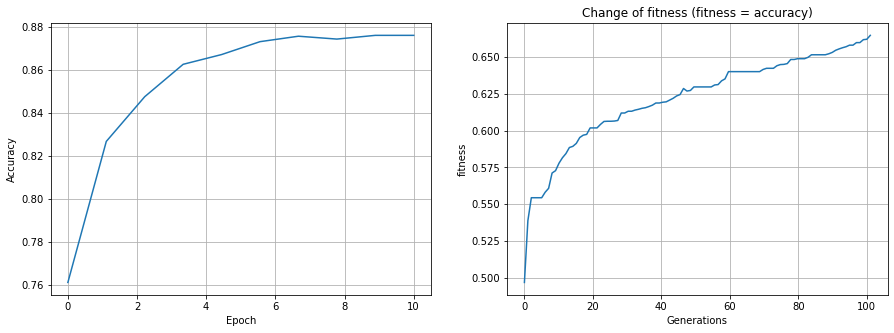

10

In [256]:
# Plotting the results
x_axis = np.linspace(0, num_epochs, num_epochs)

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(x_axis, accuracies_valid, label='SDG')
ax[0].set_ylabel("Accuracy")
ax[0].set_xlabel("Epoch")

ax[0].grid()

ax[1].plot(x_ga, cels, label='Fitness (accuracy)')
ax[1].set_ylabel("Accuracy")
ax[1].set_xlabel("Generation")
ax[1].grid()

plt.xlabel("Generations")
plt.ylabel("fitness")
plt.title("Change of fitness (fitness = accuracy)")


plt.show()

Here we see that using SDG accuracy increases and converges faster han usin Genetic algorithm. With just after 10 iterations the accuracy is near to 88 % with SDG.

Getting the result shown in plot with SDG took only 7 minutes, while getting the result shown in plot with GA took 1 hour.
We see that the trend is moving upward. If we just did wait more hours the accucay could increase even more. But the problem with GA is the speed.

And here we compare the testing results both from SDG training and GA optimization of the classifier.

In [279]:
# Testing
cel_post_SGD, acc_post_SGD = testing(model, criterion, test_loader, len(vocab))

In [280]:
# Print the comparison
from tabulate import tabulate

comparison_table = tabulate([['Mean CEL', cel_pre, cel_post_SGD, sgd_results_valid[-1], cel_post_GA, cel_post_GA_valid], 
                             ['Accuracy', acc_pre, acc_post_SGD, accuracies_valid[-1], acc_post_GA, acc_post_GA_valid]], 
                            headers=['Measure', 'Before training', 'SGD test set', 'SGD valid set', 'GA test set', 'GA valid set'])
print(comparison_table)

Measure      Before training    SGD test set    SGD valid set    GA test set    GA valid set
---------  -----------------  --------------  ---------------  -------------  --------------
Mean CEL             6.42273        0.341353         0.315179       0.734388        0.669177
Accuracy             0.5            0.864            0.876          0.589333        0.6648


Testing with GA gives even lower accuracy, but a slightly more than before training.
We see that difference between GA on valid set and testing set is higher than the difference between SDG test set and SDG valid set.

While SDG changes values of weights systematically using gradients to reduce the CEL, GA changes values of weights almost by random. So no wonder SDG

## 4. Conclusions

Even a simple neural network of 2 hidden layers with only 16-8-2 nodes using TF-IDF vectorization can classify between positive and negative IMDB movie reviews reasonably well. This was a little suprising to me as I thought since text and language is complicated such a simple network couldn't work.

Genetic Algorithm works in optimizing weights. But SGD works far more faster than GA and SGD converges faster.

SGD converges faster maybe because it may find a local minima and fail to find global minima of the loss function.
GA could get stuck into local minima too, but mutations are one of the methods that prevents that.

But would GA outperform SGD if we had given it enough generations?

One may need to run GA in 300-600 generations to see that. Even 100 generations takes 1-2 hours, so testing 600 generations would take 6 hours. Not only that, one needs to test with different parameters and different cross-over and mutation methods to fine-tune  it.

Given that so much time needs to be spent to test GA, one could rather spend that time to fine-tune with SGD.

